In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1- Loading Data

In [2]:
filepath="../project/data/"
data = pd.read_csv(f"{filepath}train.csv")
pd.set_option('display.max_colwidth', None)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


# 2- Dataset information


Training set information:
---------


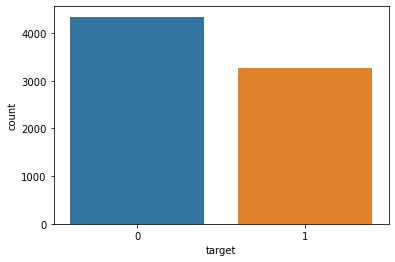

Input data has 7613 rows and, 5 column

Proportion of samples with label 1 (ie A real disaster tweet): 42.97 %
Proportion of samples with label 0 (ie Not a real disaster tweet): 57.03 %

Number of Missing Tweets = 0
Number of Missing Targets = 0


In [3]:
print("\nTraining set information:")
print("---------")
sns.countplot(x="target", data=data)
plt.show()

print(f'Input data has {len(data)} rows and, {len(data.columns)} column\n')

print("Proportion of samples with label 1 (ie A real disaster tweet):", np.round(data["target"].sum()/len(data)*100,2), "%")
print("Proportion of samples with label 0 (ie Not a real disaster tweet):", np.round((1-data["target"].sum()/len(data))*100,2),"%\n")


print(f'Number of Missing Tweets = {data["text"].isnull().sum()}')
print(f'Number of Missing Targets = {data["target"].isnull().sum()}')

# Resample Data

In [4]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = data[(data['target']==1)] 
df_minority = data[(data['target']==0)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 3300, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

-->Show value counts for each class 


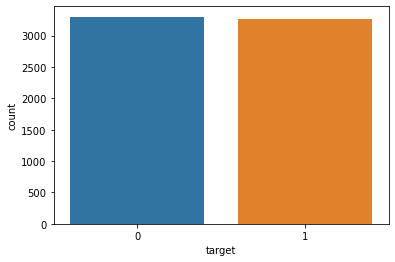

Input data has 6571 rows and, 5 column

Proportion of samples with label 1 (ie A real disaster tweet): 49.78 %
Proportion of samples with label 0 (ie Not a real disaster tweet): 50.22 %

Number of Missing Tweets = 0
Number of Missing Targets = 0


In [5]:
print("-->Show value counts for each class ")
sns.countplot(x="target", data=df_upsampled)#Show the counts of observations in each class bin using bars.
plt.show()#if i remove this line the histogram  will appeare in final 


print(f'Input data has {len(df_upsampled)} rows and, {len(df_upsampled.columns)} column\n')

print("Proportion of samples with label 1 (ie A real disaster tweet):", np.round(df_upsampled["target"].sum()/len(df_upsampled)*100,2), "%")
print("Proportion of samples with label 0 (ie Not a real disaster tweet):", np.round((1-df_upsampled["target"].sum()/len(df_upsampled))*100,2),"%\n")


print(f'Number of Missing Tweets = {df_upsampled["text"].isnull().sum()}')
print(f'Number of Missing Targets = {df_upsampled["target"].isnull().sum()}')

# 3- Dataset Cleaning
As the text in these samples are tweets, there may be twitter handles or hashtags that are nonsense, but some handles for example could be for an emergency service account which can help us in our prediction. There also may be links in a tweet, which will not be as helpful and we can remove. 

The function will 
* remove the @ and # of handles and hashtags
* set text to lowercase
* remove html characters
* remove Emails ex. sebaiy@gmail.com
* convert apostrophe contractions to their full counterparts ex. i'm ==> i am
* remove hyperlinks
* remove stopwords
* remove punctuation 
* remove weird quirks from tweets such as "û_" and "vÌ_deo"

In [6]:
import html
import re
import nltk
#nltk.download("stopwords")
#nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import ImageColorGenerator
import string

In [7]:
stop_words = set(stopwords.words('english'))

wnl = WordNetLemmatizer()  
set(string.punctuation)
stop_words.add('u')

Apos_dict={"'s":" is","won't":"will not", "can't":"cannot","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}

def clean_text(text):
    
    text=text.lower()
    
    text=html.unescape(text) # remove html tag words
    
    for key,value in Apos_dict.items(): # remove contractions
        if key in text:
            text = text.replace(key,value)

    text=re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{1,4}\b", "", text) #emails like (sebaiy.mohamed@gmail.com)
    
    text=re.sub(r"[À-ÿ]+", "", text) #remove sympols like ([À, Ç, Ë,.., ÿ)
    
    text=re.sub(r'https?:\/\/.\S+', "",text)    # remove links
    
    text=re.sub(r'\S*û_*\S*|@\w*|#\w*', "",text) # remove u_, handles and just the hashtag froms hashtags
    
    text=re.sub(r'[0-9]', "", text) #remove numbers

    text=re.sub(r'[^\w\s]', "",text)# remove any character not in the set [^] ie punctuation, can add # | @ here

    no_stopwords = [i for i in  WhitespaceTokenizer().tokenize(text) if i not in stop_words]
    
    n_lemma = [wnl.lemmatize(i, pos= 'n') for i in  no_stopwords] # nouns Lemmatizations
    v_lemma = [wnl.lemmatize(i, pos= 'v') for i in  n_lemma] # verb Lemmatizations
    a_lemma = [wnl.lemmatize(i, pos= 'a') for i in  v_lemma] # adjectives Lemmatizations
    r_lemma = [wnl.lemmatize(i, pos= 'r') for i in  a_lemma] # adverbs Lemmatizations
    s_lemma = [wnl.lemmatize(i, pos= 's') for i in  r_lemma] # satellite adjectives Lemmatization
    
    # remove punctuation
    no_punct = []
    
    for word in s_lemma:
        s = ""
        for ch in word:
            if ch not in set(string.punctuation):
                s = f'{s}{ch}'
        no_punct.append(s)
        
    text = " ".join(no_punct)       
    return text

#print(f"An example\nThe uncleaned tweet: {data['text'].loc[71]}")
#print(f"The cleaned tweet: {clean_text(data['text'].loc[71])}")

In [8]:
cleaned_data = pd.DataFrame()

cleaned_data["text"] = df_upsampled["text"].apply(clean_text)

cleaned_data["target"] = df_upsampled["target"]
cleaned_data.head()

,text,target
1328,burn man ticket vehicle pas full read ebay,0
6520,help survive zombie apocalypse zombie fun run november th,0
5359,though panic disco say,0
747,yo timeline blow damn fast,0
5959,harshness follow u good day sarah c race think scream siren pace back forth,0


# Splitting Data

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection

In [10]:
x_train_data, x_test_data, y_train, y_test = model_selection.train_test_split(cleaned_data["text"], cleaned_data["target"], test_size=0.2, random_state=0)

# Vectorization

In [11]:
vectorisers={"tf_idf": TfidfVectorizer(stop_words='english',
                                                          analyzer="word",
                                                          ngram_range=(1,2),
                                                          max_features=None,
                                                          min_df=0.0004)}
vec = vectorisers["tf_idf"]
vec_train = np.array(cleaned_data["text"])
vec = vec.fit(np.array(vec_train))

x_train = vec.transform(np.array(x_train_data))
x_test = vec.transform(np.array(x_test_data))

In [12]:
print(f"Tweet: {cleaned_data['text'][5]}")
print(f"Vectorised tweet:\n{x_train[5]}")

Tweet: update california hwy close direction due lake county fire
Vectorised tweet:
  (0, 2205)	1.0


# Accuracy Display

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def conf_metric(m, y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred, labels=m.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m.classes_)
    disp.plot()
    plt.show()
    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:", f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%')


# Support Vector Machine 

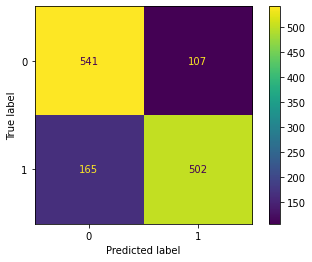

Accuracy: 79.32%


In [14]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

conf_metric(clf, y_test, y_pred)


# Multinomial NB
* Multinomial Naive Bayes: Feature vectors represent the frequencies with which certain events have been generated by a multinomial distribution. This is the event model typically used for document classification.

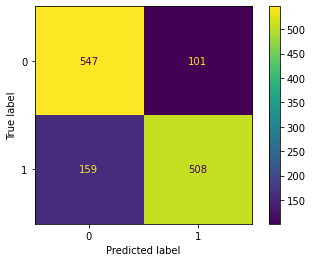

Accuracy: 80.23%
CPU times: total: 125 ms
Wall time: 117 ms


In [15]:
%%time
from sklearn.naive_bayes import MultinomialNB
myClassifier = MultinomialNB()

#Train the model using the training sets
myClassifier.fit(x_train, y_train)

y_pred = myClassifier.predict(x_test)
        
conf_metric(myClassifier, y_test, y_pred)


# Logisitic Regression

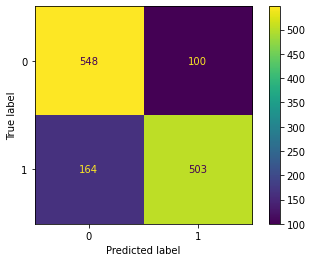

Accuracy: 79.92%
CPU times: total: 516 ms
Wall time: 179 ms


In [16]:
%%time
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression()          
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)
conf_metric(logreg, y_test, y_pred)
 

# Random Forest

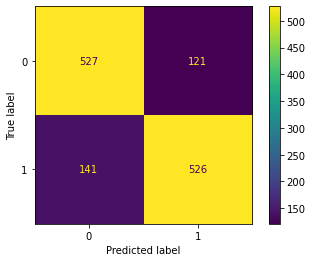

Accuracy: 80.08%
CPU times: total: 5.12 s
Wall time: 5.01 s


In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier

RF= RandomForestClassifier()          
RF.fit(x_train, y_train)

y_pred = RF.predict(x_test)
conf_metric(RF, y_test, y_pred)

# KNN

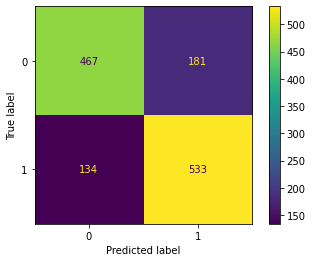

Accuracy: 76.05%


In [18]:
#import KNN model 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors =81, metric = 'cosine', n_jobs=-1)

#train to model
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
conf_metric(knn, y_test, y_pred)

# Bernoulli Naive Bayes model
* Bernoulli Naive Bayes: In the multivariate Bernoulli event model, features are independent booleans (binary variables) describing inputs. Like the multinomial model, this model is popular for document classification tasks, where binary term occurrence(i.e. a word occurs in a document or not) features are used rather than term frequencies(i.e. frequency of a word in the document).

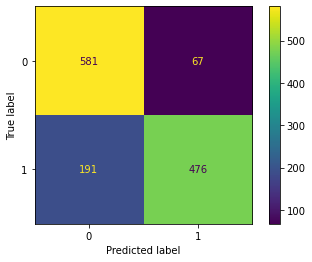

Accuracy: 80.38%


In [19]:
#import Navie-Bayse model 
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)

y_pred = bnb.predict(x_test)
conf_metric(bnb, y_test, y_pred)

# Combination

In [20]:
all_classifiers = list()

all_classifiers.append(clf)
all_classifiers.append(myClassifier)
all_classifiers.append(logreg)
all_classifiers.append(RF)
all_classifiers.append(knn)
all_classifiers.append(bnb)

In [21]:
def compination(tweet,all_classifiers):
    if type(tweet)!=type(x_train):
        tweet = vec.transform(np.array(tweet))
        
    counter_list = [0, 0]
    
    for i in range(len(all_classifiers)):
        
        p = all_classifiers[i].predict(tweet)

        if p[0] == 0:
            counter_list[0]+=1
        else:
            counter_list[1]+=1
            
    if counter_list[0] > counter_list[1]:
        return 0
    
    elif counter_list[0] < counter_list[1]:
        return 1

    else:
        n = np.random.randint(0, len(all_classifiers))
        t = all_classifiers[n].predict(tweet)
        return t[0]

In [22]:
def compination_list(tweet, x_test_rar, all_classifiers):
    def tras(t):
        if t == 0:
            return "Not Disaster"
        return "Disaster"
    
    y_pre = list()
    countT = []
    countF = []

    if type(tweet) != type(x_train):
        tweet = vec.transform(np.array(tweet))
        
    for i in tweet:
        y_pre.append(compination(i, all_classifiers))
        
    print("Accuracy:", f'{round(accuracy_score(y_test, y_pre) * 100, 2)}%')

    t = pd.DataFrame({
            "tweet" : x_test_rar,
            "True" : y_test,
            "predict" : y_pre 
            })
    t['True'] = t['True'].apply(tras)
    t['predict'] = t['predict'].apply(tras)    
    return t

In [23]:
a = compination_list(x_test, x_test_data, all_classifiers)

Accuracy: 80.84%


In [24]:
a.head()

,tweet,True,predict
4303,beware temper loose tongue two dangerous weapon combine lead person hellfire,Not Disaster,Not Disaster
3152,myanmar flood childfund international need care aust appeal,Disaster,Disaster
6542,whether pressure non wud survive even thalapathi release,Disaster,Not Disaster
4061,pharrell prevent forest fire,Not Disaster,Not Disaster
6111,sink slipper put boot,Not Disaster,Not Disaster
